<div align="center">
    <img src="images/logo_fmkn.png" alt="logo_fmkn" />
</div>

# Введение в рекуррентные нейронные сети

### Занятие 3. Собственно рекуррентные нейронные сети

<br />
<br />
17-18 января 2022

### Недостатки (сверточных) нейронных сетей или зачем нужны рекуррентные

 * на входе только вектора фиксированной размерности (например, изображения 28x28)
 * на выходе тоже размерность фиксирована (например, вероятности классов)
 * фиксированное число вычислительных шагов (т.е. архитектура сети)

<div align="center">
    <img src="images/rnn_architectures.jpg" alt="rnn_architectures" width=1000 />
</div>

[A. Karpathy. The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

<div align="center">
    <img src="images/one-to-one.jpg" width=100 />
    Vanilla Neural Networks
</div>

<div align="center">
    <img src="images/one-to-many.jpg" width=200 />
    $\text{Image Captioning} \\
     (\text{image} \to \text{sequence of words})$
</div>

<div align="center">
    <img src="images/many-to-one.jpg" width=200 />
    $\text{Sentiment Classification} \\ 
     (\text{sequence of words} \to \text{sentiment})$
</div>

<div align="center">
    <img src="images/many-to-many.jpg" width=300 />
    $\text{Machine Translation} \\ 
     (\text{seq of words} \to \text{seq of words})$
</div>

<div align="center">
    <img src="images/many-to-many-2.jpg" width=200 />
    $\text{Video Classification} \\ 
     (\text{on frame level})$
</div>


<div align="center">
    Последовательная обработка фиксированного входа
    <img src="images/house_read.gif" alt="house_read" width=300 />
</div>
    
[J. Ba, V. Mnih, K. Kavukcuoglu. Multiple Object Recognition with Visual Attention](https://arxiv.org/abs/1412.7755)

<div align="center">
    Последовательная обработка для фиксированного выхода
    <img src="images/house_generate.gif" alt="house_generate" width=500 />
</div>

[K. Gregor, I. Danihelka, A. Graves, D. J. Rezende, D. Wierstra. DRAW: A Recurrent Neural Network For Image Generation](https://arxiv.org/abs/1502.04623)

### Рекуррентная нейронная сеть

<div align="center">
    <img src="images/rnn_scheme.png" width=200/>
</div>


### Рекуррентная нейронная сеть

Обычно хотим что-то предсказать :)

<div align="center">
    <img src="images/rnn_scheme_y.png" width=200/>
</div>


### Рекуррентная нейронная сеть

Обрабатываем последовательность векторов $x$ **одной и той же** функцией с параметрами:

$$ h_t = f_W(h_{t-1}, x_t)$$

$f_W$ — функция, параметризованная $W$

$x_t$ — очередной входной вектор

$h_t$ — скрытое состояние


### Простейшая (vanilla) рекуррентная нейронная сеть

Оставляем один скрытый вектор $h$:

$$ h_t = f_W(h_{t-1}, x_t)$$

В качестве функции $f_W$ задаём линейное преобразование с нелинейной «сигмоидой» по компонентам:

$$ h_t = \tanh (W_{hh} h_{t-1} + W_{xh} x_t) \\
   y_t = W_{hy} h_t
$$


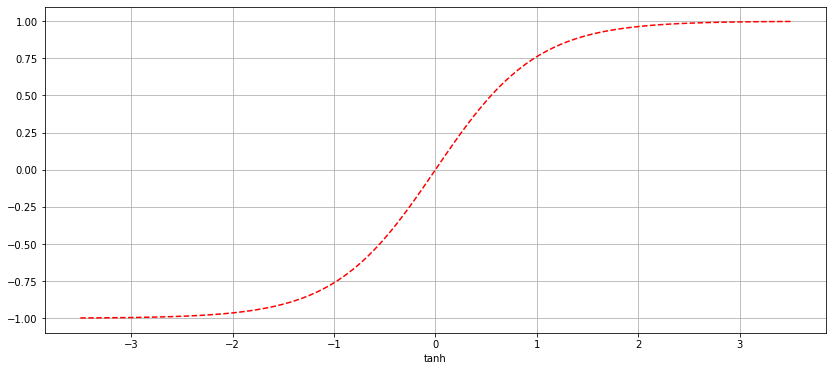

In [1]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1)

ax.set_xlabel('tanh')

x = np.linspace(-3.5, 3.5, num=100)
tanh = np.tanh(x) 
ax.plot(x, tanh, 'r--', label='tanh')

ax.grid(True)

fig.set_size_inches(14, 6)

plt.show()

### Пример модели на уровне символов

 * Весь словарь из четырёх букв: $[h, e, l, o]$

<div align="center">
    <img src="images/rnn_char_level_example.jpg" width=500/>
</div>

 * к значениям выходного слоя для получения функции потерь ещё применяется *softmax*

Реализация на numpy:
https://gist.github.com/karpathy/d4dee566867f8291f086


### Загрузка данных

In [2]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np

# data I/O
data = open('input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 61609 characters, 83 unique.


In [7]:
' '.join(chars)

'C . # X f   i A N ” 1 e 2 R U © h “ z * a y ‘ Z u 8 b n m – B c Y s r … k : x l 5 , — 3 Q L g v D G ; 6 p I H O ’ - F J q E / t \n S 7 4 o d T K 9 j & W 0 V ! P ? w M'

### Инициализация

In [7]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

<div align="left">
    <img src="images/rnn_char_level_example.jpg" width=400/>
</div>

### Основной цикл

In [18]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

In [31]:
while n < 5*10**5 + 1000: #True 
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]
  
    # sample from the model now and then
    if n % 1000 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))
  
    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 1000 == 0: 
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
    
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update
  
    p += seq_length # move data pointer
    n += 1 # iteration counter 

----
 ethon bonciont, tholany aysigimed awr dome hiate stat up onzeause, she revoryly ampoul suapent’s that fally the concave hat?”

Ye Zhet. In sten the burt sbe, wave san ins matcourted with. She lavely s 
----
iter 500000, loss: 42.647056


### Функция потерь

 * прямой проход для расчета потерь
 * обратное распространение ошибки (backpropagation)


Обозначим компоненты вектора вероятностей символов (классов) на выходе RNN через
$$ p_k = \frac{e^{f_k}}{\sum\limits_j e^{f_j}}$$

Тогда значение функции потерь на очередном объекте $x_i$
$$ L_i = -\ln (p_{y_i})$$

Тогда можно прямым вычислением производной получить
$$ \frac{\partial L_i}{\partial f_k} = p_k - 1(y_i = k)$$

In [17]:
def lossFun(inputs, targets, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [15]:
def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

### 0 итераций

----
 *t1HCnzGO––3A tnqt
zjhfCh
s4”27cqI? np…2‘—N.is;J&Y  * 5WwaSSgaeW3n8.Vtx18m9qsU
9– * oh,’!u’gimp9?;rofmkB4#C8drK’M…2 1/ E!’ wHLHv&:O‘Gcbg!‘M6 i–o,IAdjb–cK;s/BFJ#dH NOI7W.4rE9!3gh6c.*7TyHoA.-?Uu
?eKrH1S

----

### 1000 итераций
----
 d s hose9rgl.cho  t  idorhiti tmnt l ayn  she trd lrdry  tosi…tet ulsnnf nosctnea  ’oloutTtdlea
gruc’saN a r oaeed sly nuGtsmhney tee Yh*tYs iameaplo d ieWe rtee oeeovottoehgnR o rgalt hp c. rmsesloni 

----

### $10^4$ итераций
----
 itiowor


1 atta tottzopito pot.   7 The Yeftheg allelse Garel.

:
3*don Yemang Ret anke alen Awuwe hime avesclac mowt oaly felact ensiline anon Insadnmede afty or, honsilander cueleng Nonatont’e the  

----


### $10^5$ итераций

----

 t yed arn crilvely nill and sook reagit thiece mo freatt to was asle to the ence the you the cranit, and the Rea licters thathere in who be tow bes rown tails and recoI was fertarjoole plepletine the  

----

### $5*10^5$ итераций

----
 ethon bonciont, tholany aysigimed awr dome hiate stat up onzeause, she revoryly ampoul suapent’s that fally the concave hat?”

Ye Zhet. In sten the burt sbe, wave san ins matcourted with. She lavely s 

----


### Резюме

 * Рекуррентные нейронные сети — простой, мощный и гибкий подход решения различных задач машинного обучения
 * Даже на vanilla RNN уже можно обучать и генерировать интересное
   
### Что ещё можно посмотреть?
 * Лекция 10 курса «CS231n» Andrej Karpathy в Стенфорде: https://www.youtube.com/watch?v=iX5V1WpxxkY
 * Как тренировать нейросети? http://karpathy.github.io/2019/04/25/recipe/
 * Аналогичное занятие курса Школы анализа данных: https://github.com/yandexdataschool/Practical_DL/tree/fall21/week06_rnn